In [14]:
import skimage
import skimage.measure
import numpy

Check scikit-image API
=================

In [15]:
image = numpy.array([[0, 0, 0, 0, 0, 0],
                     [0, 1, 0, 0, 0, 1],
                     [0, 0, 1, 0, 0, 1],
                     [0, 0, 0, 0, 0, 1]], dtype=numpy.float32)

polygons = skimage.measure.find_contours(image, level=0.5)
print(polygons)

[array([[1.5, 1. ],
       [1. , 0.5],
       [0.5, 1. ],
       [1. , 1.5],
       [1.5, 1. ]]), array([[3. , 4.5],
       [2. , 4.5],
       [1. , 4.5],
       [0.5, 5. ]]), array([[2.5, 2. ],
       [2. , 1.5],
       [1.5, 2. ],
       [2. , 2.5],
       [2.5, 2. ]])]


In [16]:
image = numpy.array([[0, 0, 0, 0, 0, 0],
                     [0, 0, 1, 1, 0, 0],
                     [0, 1, 1, 1, 1, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0]], dtype=numpy.float32)

polygons = skimage.measure.find_contours(image, level=0.5)
print(polygons)

[array([[3.5, 2. ],
       [3. , 1.5],
       [2.5, 1. ],
       [2. , 0.5],
       [1.5, 1. ],
       [1. , 1.5],
       [0.5, 2. ],
       [0.5, 3. ],
       [1. , 3.5],
       [1.5, 4. ],
       [2. , 4.5],
       [2.5, 4. ],
       [2.5, 3. ],
       [3. , 2.5],
       [3.5, 2. ]])]


Utils
=====

In [17]:
%matplotlib nbagg

In [18]:
class MarchingSquareSciKitImage(object):

    def __init__(self, image, mask=None):
        import skimage.measure
        self._image = image
        self._mask = mask
        x, y = numpy.mgrid[:self._image.shape[0], :self._image.shape[1]]

    _deltas = [(0.0, 0.0), (0.99, 0.0), (0.0, 0.99), (0.99, 0.99)]

    def _flag_coord_over_mask(self, coord):
        """Flag coord over the mask as NaN"""
        for dx, dy in self._deltas:
            if self._mask[int(coord[0] + dx), int(coord[1] + dy)] != 0:
                return float("nan"), float("nan")
        return coord

    def iso_contour(self, value):
        import skimage.measure
        polylines = skimage.measure.find_contours(self._image, level=value)
        result = []
        for polyline in polylines:
            if self._mask is not None:
                polyline = map(self._flag_coord_over_mask, polyline)
                polyline = list(polyline)
                polyline = numpy.array(polyline)
            # swap x and y columns
            polyline = numpy.array([polyline[:,1], polyline[:,0]]).T
            result.append(polyline)
        return result

In [19]:
def plot_problem(problem, marching_square):
    import matplotlib
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection
    import matplotlib.pyplot as plt
    matplotlib.interactive(True)

    fig, ax = plt.subplots()
    ax.set_xmargin(0.1)
    ax.set_ymargin(0.1)
    ax.set_ylim([0, problem.image.shape[0]])
    ax.set_xlim([0, problem.image.shape[1]])
    ax.invert_yaxis()

    # image
    plt.imshow(problem.image, cmap="Greys", alpha=.5)
    
    # mask
    mask = numpy.ma.masked_where(problem.mask == 0, problem.mask)
    plt.imshow(mask, cmap="cool", alpha=.5)

    # iso contours
    colors = ["#9400D3", "#4B0082", "#0000FF", "#00FF00", "#FFFF00", "#FF7F00", "#FF0000"]
    for ivalue, value in enumerate(problem.values):
        color = colors[ivalue % len(colors)]
        polygons = marching_square.iso_contour(value)
        for p in polygons:
            p = Polygon(p, fill=False, edgecolor=color, closed=False)
            ax.add_patch(p)

    plt.show()

In [20]:
import numpy
import collections
import os

Problem = collections.namedtuple("Problem", ["image", "mask", "values"])

ROOT = os.getcwd()

def create_test_problem():
    import fabio
    data = fabio.open(ROOT + "/data/data.tif").data
    mask = fabio.open(ROOT + "/data/mask.tif").data
    mask = mask == 0
    values = range(10, 1000, int(240/6))[0:7]
    return Problem(data, mask, values)

def create_wos_problem():
    # Problem containing a WOS XPad with pixel displacment and mask
    import fabio
    data = numpy.load(ROOT + "/data/wos_tth.npz")
    image = data["tth"]
    mask = fabio.open(ROOT + "/data/wos_mask.edf").data
    mask = (mask != 0)
    values = data["angles"]
    return Problem(image, mask, values)

def create_id22_17_problem():
    # Problem containing an image of 4096x4096 with 17 rings
    data = numpy.load(ROOT + "/data/id22_17.npz")
    image = data["tth"]
    mask = (data["mask"] != 0)
    values = data["angles"]
    return Problem(image, mask, values)

def create_id22_1441_problem():
    # Problem containing an image of 4096x4096 with 1441 rings
    data = numpy.load(ROOT + "/data/id22_1441.npz")
    image = data["tth"]
    mask = (data["mask"] != 0)
    values = data["angles"]
    return Problem(image, mask, values)

Test without mask
====

In [21]:
problem = create_test_problem()
marching_square = MarchingSquareSciKitImage(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]

111 ms ± 995 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>


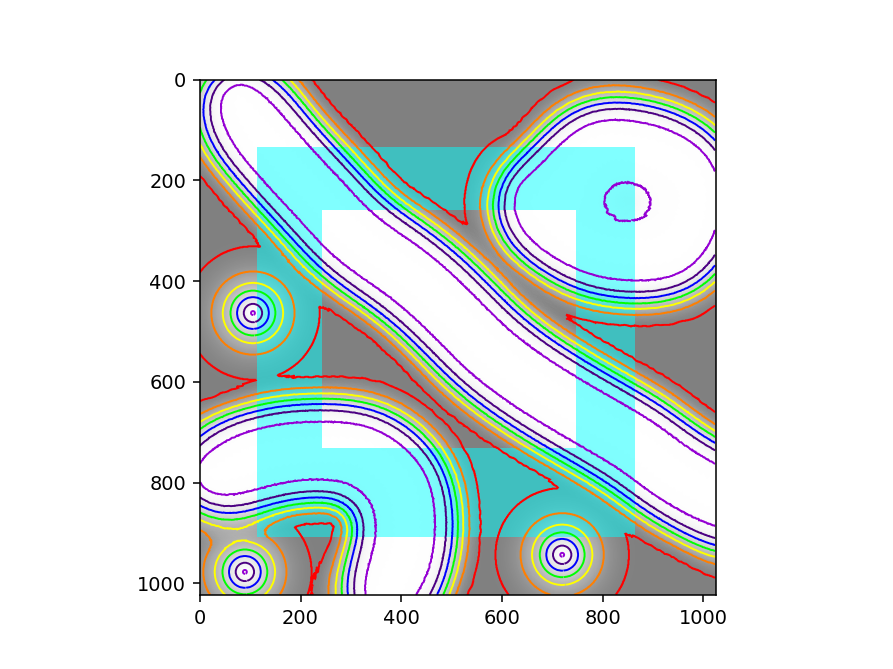

In [22]:
problem = create_test_problem()
marching_square = MarchingSquareSciKitImage(problem.image)
plot_problem(problem, marching_square)

Test with mask
==============

In [23]:
problem = create_test_problem()
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]

368 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


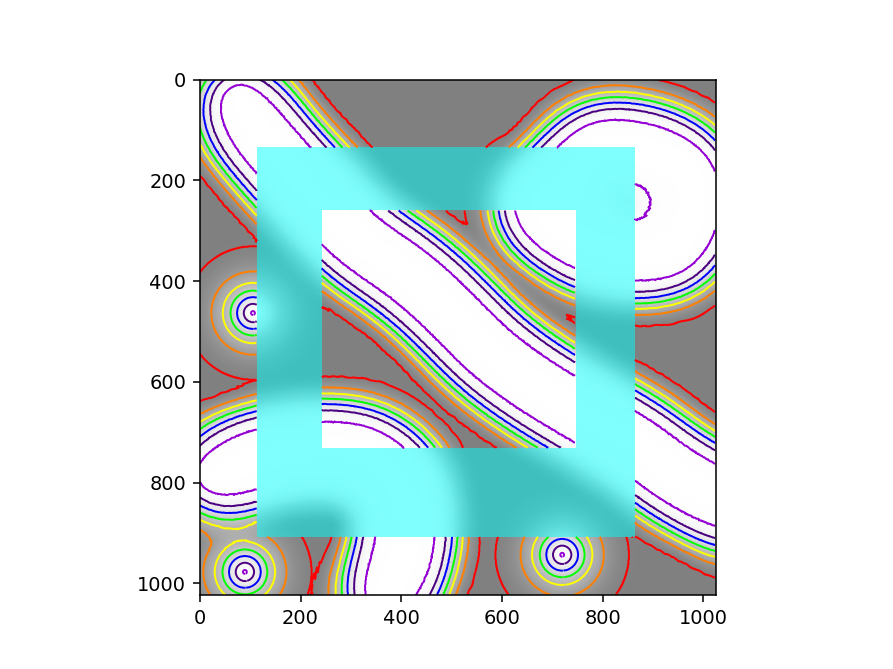

In [24]:
problem = create_test_problem()
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
plot_problem(problem, marching_square)

WOS detector (700K pixels)
===

In [25]:
problem = create_wos_problem()
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]

449 ms ± 5.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


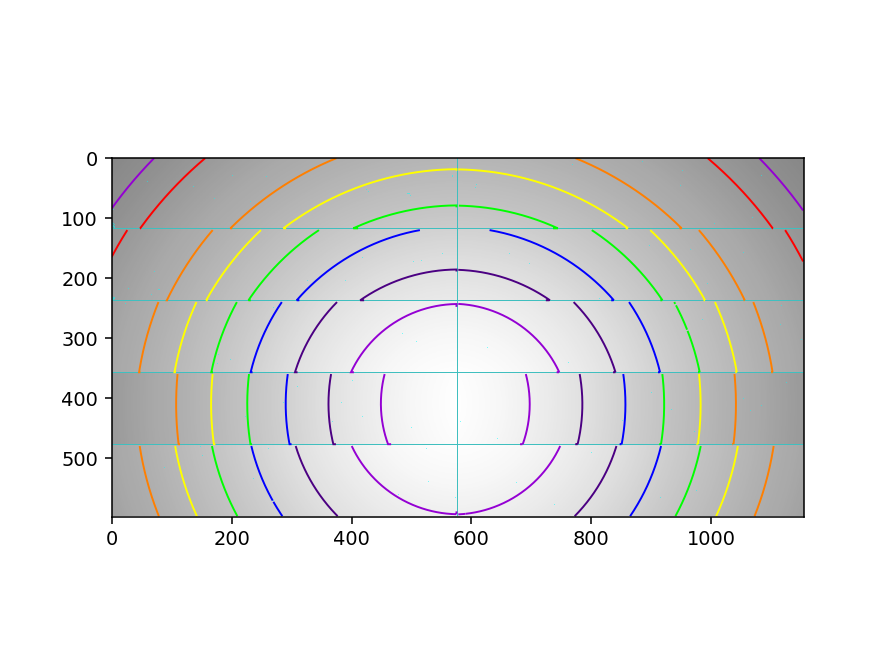

In [26]:
problem = create_wos_problem()
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
plot_problem(problem, marching_square)

Perkin Elmer (16M pixels)
===================

In [27]:
problem = create_id22_17_problem()
print("With mask")
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
%timeit [marching_square.iso_contour(a) for a in problem.values]
print("Without mask")
marching_square = MarchingSquareSciKitImage(problem.image)
%timeit [marching_square.iso_contour(a) for a in problem.values]

With mask
1.86 s ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Without mask
1.62 s ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>


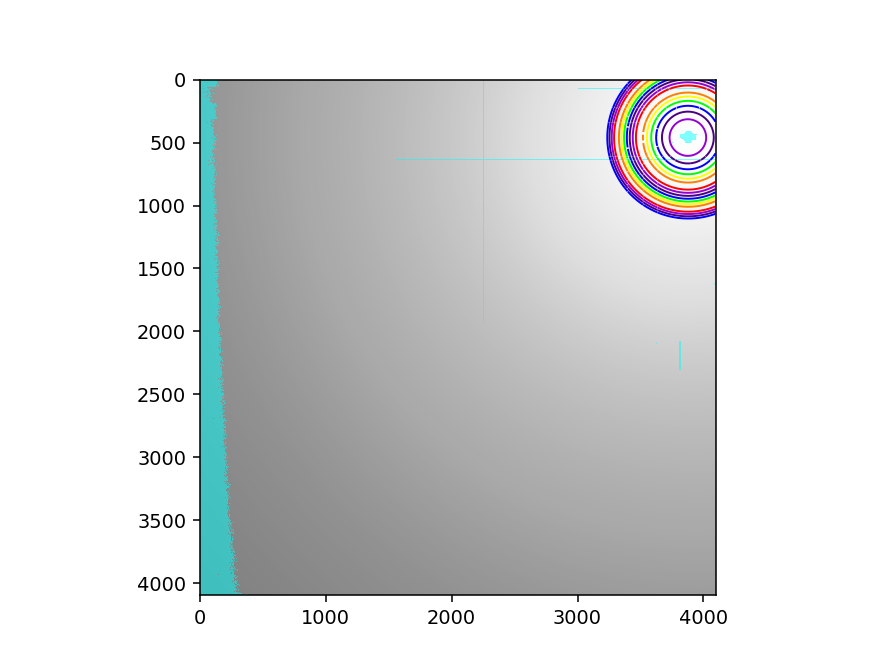

In [28]:
problem = create_id22_17_problem()
marching_square = MarchingSquareSciKitImage(problem.image, problem.mask)
plot_problem(problem, marching_square)